In [ ]:
%cd /content/
!git clone https://github.com/sirius-ai/LPRNet_Pytorch.git
%cd LPRNet_Pytorch/

In [ ]:
%cd /content/LPRNet_Pytorch
!python test_LPRNet.py

# 下载数据集

## 使用生成器生成数据集

In [ ]:
# 导入相关项目
%cd /content/
!git clone https://github.com/szad670401/end-to-end-for-chinese-plate-recognition.git
%cd end-to-end-for-chinese-plate-recognition/

/content
Cloning into 'end-to-end-for-chinese-plate-recognition'...
remote: Enumerating objects: 286, done.
remote: Total 286 (delta 0), reused 0 (delta 0), pack-reused 286
Receiving objects: 100% (286/286), 36.80 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/end-to-end-for-chinese-plate-recognition


In [ ]:
#coding=utf-8
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import cv2;
import numpy as np;
import os;
from math import *


# font = ImageFont.truetype("Arial-Bold.ttf",14)

index = {"京": 0, "沪": 1, "津": 2, "渝": 3, "冀": 4, "晋": 5, "蒙": 6, "辽": 7, "吉": 8, "黑": 9, "苏": 10, "浙": 11, "皖": 12,
         "闽": 13, "赣": 14, "鲁": 15, "豫": 16, "鄂": 17, "湘": 18, "粤": 19, "桂": 20, "琼": 21, "川": 22, "贵": 23, "云": 24,
         "藏": 25, "陕": 26, "甘": 27, "青": 28, "宁": 29, "新": 30, "0": 31, "1": 32, "2": 33, "3": 34, "4": 35, "5": 36,
         "6": 37, "7": 38, "8": 39, "9": 40, "A": 41, "B": 42, "C": 43, "D": 44, "E": 45, "F": 46, "G": 47, "H": 48,
         "J": 49, "K": 50, "L": 51, "M": 52, "N": 53, "P": 54, "Q": 55, "R": 56, "S": 57, "T": 58, "U": 59, "V": 60,
         "W": 61, "X": 62, "Y": 63, "Z": 64};

chars = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
             "B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
             "Y", "Z"
             ];

def AddSmudginess(img, Smu):
    rows = r(Smu.shape[0] - 50)

    cols = r(Smu.shape[1] - 50)
    adder = Smu[rows:rows + 50, cols:cols + 50];
    adder = cv2.resize(adder, (50, 50));
    #   adder = cv2.bitwise_not(adder)
    img = cv2.resize(img,(50,50))
    img = cv2.bitwise_not(img)
    img = cv2.bitwise_and(adder, img)
    img = cv2.bitwise_not(img)
    return img

def rot(img,angel,shape,max_angel):
    """ 使图像轻微的畸变

        img 输入图像
        factor 畸变的参数
        size 为图片的目标尺寸

    """
    size_o = [shape[1],shape[0]]

    size = (shape[1]+ int(shape[0]*cos((float(max_angel )/180) * 3.14)),shape[0])


    interval = abs( int( sin((float(angel) /180) * 3.14)* shape[0]));

    pts1 = np.float32([[0,0]         ,[0,size_o[1]],[size_o[0],0],[size_o[0],size_o[1]]])
    if(angel>0):

        pts2 = np.float32([[interval,0],[0,size[1]  ],[size[0],0  ],[size[0]-interval,size_o[1]]])
    else:
        pts2 = np.float32([[0,0],[interval,size[1]  ],[size[0]-interval,0  ],[size[0],size_o[1]]])

    M  = cv2.getPerspectiveTransform(pts1,pts2);
    dst = cv2.warpPerspective(img,M,size);

    return dst;

def rotRandrom(img, factor, size):
    shape = size;
    pts1 = np.float32([[0, 0], [0, shape[0]], [shape[1], 0], [shape[1], shape[0]]])
    pts2 = np.float32([[r(factor), r(factor)], [ r(factor), shape[0] - r(factor)], [shape[1] - r(factor),  r(factor)],
                       [shape[1] - r(factor), shape[0] - r(factor)]])
    M = cv2.getPerspectiveTransform(pts1, pts2);
    dst = cv2.warpPerspective(img, M, size);
    return dst;



def tfactor(img):
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV);

    hsv[:,:,0] = hsv[:,:,0]*(0.8+ np.random.random()*0.2);
    hsv[:,:,1] = hsv[:,:,1]*(0.3+ np.random.random()*0.7);
    hsv[:,:,2] = hsv[:,:,2]*(0.2+ np.random.random()*0.8);

    img = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR);
    return img

def random_envirment(img,data_set):
    index=r(len(data_set))
    env = cv2.imread(data_set[index])

    env = cv2.resize(env,(img.shape[1],img.shape[0]))

    bak = (img==0);
    bak = bak.astype(np.uint8)*255;
    inv = cv2.bitwise_and(bak,env)
    img = cv2.bitwise_or(inv,img)
    return img

def GenCh(f,val):
    img=Image.new("RGB", (45,70),(255,255,255))
    draw = ImageDraw.Draw(img)
    draw.text((0, 3),val,(0,0,0),font=f)
    img =  img.resize((23,70))
    A = np.array(img)

    return A
def GenCh1(f,val):
    img=Image.new("RGB", (23,70),(255,255,255))
    draw = ImageDraw.Draw(img)
    draw.text((0, 2),val,(0,0,0),font=f)
    A = np.array(img)
    return A
def AddGauss(img, level):
    return cv2.blur(img, (level * 2 + 1, level * 2 + 1));


def r(val):
    return int(np.random.random() * val)

def AddNoiseSingleChannel(single):
    diff = 255-single.max();
    noise = np.random.normal(0,1+r(6),single.shape);
    noise = (noise - noise.min())/(noise.max()-noise.min())
    noise= diff*noise;
    noise= noise.astype(np.uint8)
    dst = single + noise
    return dst

def addNoise(img,sdev = 0.5,avg=10):
    img[:,:,0] =  AddNoiseSingleChannel(img[:,:,0]);
    img[:,:,1] =  AddNoiseSingleChannel(img[:,:,1]);
    img[:,:,2] =  AddNoiseSingleChannel(img[:,:,2]);
    return img;


class GenPlate:


    def __init__(self,fontCh,fontEng,NoPlates):
        self.fontC =  ImageFont.truetype(fontCh,43,0);
        self.fontE =  ImageFont.truetype(fontEng,60,0);
        self.img=np.array(Image.new("RGB", (226,70),(255,255,255)))
        self.bg  = cv2.resize(cv2.imread("./images/template.bmp"),(226,70));
        self.smu = cv2.imread("./images/smu2.jpg");
        self.noplates_path = [];
        for parent,parent_folder,filenames in os.walk(NoPlates):
            for filename in filenames:
                path = parent+"/"+filename;
                self.noplates_path.append(path);


    def draw(self,val):
        offset= 2 ;

        self.img[0:70,offset+8:offset+8+23]= GenCh(self.fontC,val[0]);
        self.img[0:70,offset+8+23+6:offset+8+23+6+23]= GenCh1(self.fontE,val[1]);
        for i in range(5):
            base = offset+8+23+6+23+17 +i*23 + i*6 ;
            self.img[0:70, base  : base+23]= GenCh1(self.fontE,val[i+2]);
        return self.img
    def generate(self,text):
        if len(text) == 7:
            fg = self.draw(text);
            fg = cv2.bitwise_not(fg);
            com = cv2.bitwise_or(fg,self.bg);
            com = rot(com,r(60)-30,com.shape,30);
            com = rotRandrom(com,10,(com.shape[1],com.shape[0]));
            #com = AddSmudginess(com,self.smu)

            com = tfactor(com)
            com = random_envirment(com,self.noplates_path);
            com = AddGauss(com, 1+r(4));
            com = addNoise(com);


            return com
    def genPlateString(self,pos,val):
        plateStr = "";
        box = [0,0,0,0,0,0,0];
        if(pos!=-1):
            box[pos]=1;
        for unit,cpos in zip(box,range(len(box))):
            if unit == 1:
                plateStr += val
            else:
                if cpos == 0:
                    plateStr += chars[r(31)]
                elif cpos == 1:
                    plateStr += chars[41+r(24)]
                else:
                    plateStr += chars[31 + r(34)]

        return plateStr;

    def genBatch(self, batchSize,pos,charRange, outputPath,size):
        if (not os.path.exists(outputPath)):
            os.mkdir(outputPath)
        for i in range(batchSize):
            plateStr = G.genPlateString(-1,-1)
            img =  G.generate(plateStr);
            img = cv2.resize(img,size);
            filename = os.path.join(outputPath, str(i).zfill(4) + '.' + plateStr + ".jpg")
            cv2.imwrite(filename, img);

G = GenPlate("./font/platech.ttf",'./font/platechar.ttf',"./NoPlates")

# G.genBatch(100000,2,range(31,65),"./plate_train",(94, 24))
G.genBatch(1000,2,range(31,65),"./plate_val",(94, 24))
G.genBatch(1000,2,range(31,65),"./plate_test",(94, 24))






#
#
# cv2.imshow("a",com)
# cv2.waitKey(0);


## 使用CCPD数据集

In [ ]:
!unzip -d / /content/drive/MyDrive/license_plate.zip
!unzip -d /content /content/drive/MyDrive/CCPD2020.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/CCPD2020/ccpd_green/test/043784722222222225-89_260-183&507_560&613-557&602_198&613_183&520_560&507-0_0_5_24_32_29_26_32-176-404.jpg  
  inflating: /content/CCPD2020/ccpd_green/test/04061302681992337-90_266-182&504_502&620-496&600_182&620_188&509_502&504-0_0_3_28_26_29_29_31-122-144.jpg  
  inflating: /content/CCPD2020/ccpd_green/test/049899425287356323-91_251-142&536_595&636-593&636_169&628_142&536_595&548-0_0_3_24_28_33_29_32-60-128.jpg  
  inflating: /content/CCPD2020/ccpd_green/test/03671875-106_247-213&385_448&542-448&542_221&459_213&385_443&457-0_0_3_26_30_30_26_33-107-61.jpg  
  inflating: /content/CCPD2020/ccpd_green/test/03821000957854406-91_255-188&473_517&580-517&580_206&558_188&473_507&484-0_0_3_26_25_24_26_25-93-98.jpg  
  inflating: /content/CCPD2020/ccpd_green/test/305224175347222222-98_119-147&392_509&538-509&538_204&489_147&392_473&435-0_0_3_26_32_29_24_31-155-235.jpg  
  inflating: /content/CCPD20

In [ ]:
# 删除数据中的空车牌（空车牌负样本用于yolov5进行目标识别，车牌检测时不需要）
import shutil
import os

father_path = '/content/license_plate/train'
for root, dirs, files in os.walk(father_path):
  for i in files:
    if len(i.split('-')) <= 2:
      p = os.path.join(father_path, i)
      os.unlink(p)

In [ ]:
# 对蓝牌和绿牌进行整合
!mv /content/CCPD2020/ccpd_green/train/* /content/license_plate/train
!mv /content/CCPD2020/ccpd_green/test/* /content/license_plate/test

In [ ]:
# 将车牌单独剪裁出来，放在单独的文件夹
import os
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/content/license_plate/test'
save_path = '/content/plates/test'
for root, dirs, files in os.walk(img_path):
  for i in files:
    img = Image.open(os.path.join(img_path, i))
    anno_str = i.split("-")
    lt, rb = anno_str[2].split('_')
    lt = list(map(int, lt.split('&')))
    rb = list(map(int, rb.split('&')))
    img = img.crop((lt[0], lt[1], rb[0], rb[1]))
    # plt.imshow(img)
    # plt.show()
    if not os.path.exists(save_path):
      os.makedirs(save_path)
    img.save(os.path.join(save_path, i), quality=95, subsampling=0)

# 网络构建

In [ ]:
import torch
from torch import nn

class small_basic_block(nn.Module):
  def __init__(self, ch_in, ch_out):
      super(small_basic_block, self).__init__()
      self.block = nn.Sequential(
        nn.Conv2d(ch_in, ch_out // 4, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(3, 1), padding=(1, 0)),
        nn.ReLU(),
        nn.Conv2d(ch_out // 4, ch_out // 4, kernel_size=(1, 3), padding=(0, 1)),
        nn.ReLU(),
        nn.Conv2d(ch_out // 4, ch_out, kernel_size=1),
      )
  def forward(self, x):
      return self.block(x)

class LPRNet(nn.Module):
  def __init__(self, class_num, dropout_rate=0.5):
    super(LPRNet, self).__init__()
    self.backbone = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1), # 0
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),  # 2
        nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1)),
        small_basic_block(ch_in=64, ch_out=128),    # *** 4 ***
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),  # 6
        nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2)),
        small_basic_block(ch_in=64, ch_out=256),   # 8
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),  # 10
        small_basic_block(ch_in=256, ch_out=256),   # *** 11 ***
        nn.BatchNorm2d(num_features=256),   # 12
        nn.ReLU(),
        nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(4, 1, 2)),  # 14
        nn.Dropout(dropout_rate),
        nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(1, 4), stride=1),  # 16
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),  # 18
        nn.Dropout(dropout_rate),
        nn.Conv2d(in_channels=256, out_channels=class_num, kernel_size=(13, 1), stride=1), # 20
        nn.BatchNorm2d(num_features=class_num),
        nn.ReLU(),  # *** 22 ***
      )
    self.container = nn.Sequential(
        nn.Conv2d(in_channels=448+class_num, out_channels=class_num, kernel_size=(1, 1), stride=(1, 1)),
    )

  def forward(self, x):
    keep_features = []
    for i, layer in enumerate(self.backbone.children()):
      x = layer(x)   # 向前传递每一层
      if i in [2, 6, 13, 22]: # [2, 4, 8, 11, 22]   # 对指定层的数据进行收集
        keep_features.append(x)

    global_context = []
    for i, f in enumerate(keep_features):
      # 为提取的层添加下采样
      if i in [0, 1]:
        f = nn.AvgPool2d(kernel_size=5, stride=5)(f)
      if i in [2]:
        f = nn.AvgPool2d(kernel_size=(4, 10), stride=(4, 2))(f)
      
      # 这里的作用类似BN，可以更好进行训练，收敛速度更快
      f_pow = torch.pow(f, 2)
      f_mean = torch.mean(f_pow)
      f = torch.div(f, f_mean)
      global_context.append(f)

    # 多尺度特征融合
    x = torch.cat(global_context, 1)
    x = self.container(x)
    logits = torch.mean(x, dim=2)
    return logits

# 数据集定义

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


# 自定义数据加载
class PlateDataSet(Dataset):
  def __init__(self, root_dir, transform=None, target_transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.target_transform = target_transform
    self.images = os.listdir(self.root_dir)
    # 标签定义
    self.labels = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
             "B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
             "Y", "Z", "-"]

    # CCPD中字符的位置
    self.provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "-"]
    self.alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '-']
    self.ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-']

  def __len__(self):
    return len(self.images)
  
  # 如果使用生成器生成，则使用如下代码
  # def __getitem__(self, index):
  #   image_index = self.images[index]
  #   img_path = os.path.join(self.root_dir, image_index)

  #   # 只识别车牌，所以首先要把车牌给找到
  #   img = Image.open(img_path)
  #   # plt.imshow(img)
  #   # plt.show()
  #   # label为车牌号
  #   label_str = img_path.split(".")[1]
  #   label = []
  #   for i in range(len(label_str)):
  #     label.append(torch.tensor(self.labels.index(label_str[i])))
  #   if self.transform:
  #     # plt.imshow(img)
  #     # plt.show()
  #     img = self.transform(img)

  #   length = torch.tensor(len(label))
  #   label = torch.tensor(label) # 将label转化为tensor
  #   return img, label, length

  # 如果使用CCPD数据集，则使用如下代码
  def __getitem__(self, index):
    image_index = self.images[index]
    img_path = os.path.join(self.root_dir, image_index)

    # 只识别车牌，所以首先要把车牌给找到
    img = Image.open(img_path)
    # plt.imshow(img)
    # plt.show()
    anno_str = img_path.split("-")
    # print(anno_str)
    # print(anno_str[2])
    # 找到对应车牌位置
    # lt, rb = anno_str[2].split("_")
    # lt = list(map(int, lt.split('&')))
    # rb = list(map(int, rb.split('&')))
    # img = img.crop((lt[0], lt[1], rb[0], rb[1]))
    # plt.imshow(img)
    # plt.show()
    # label为车牌号
    # print(anno_str[4])
    label = list(map(int, anno_str[4].split('_')))
    label_char = []
    label_char.append(self.provinces[label[0]])
    label_char.append(self.alphabets[label[1]])
    for i in label[2:]:
      label_char.append(self.ads[i])
    # print(label_char)
    # 与labels进行映射
    labels = []
    for i in range(len(label_char)):
      labels.append(torch.tensor(self.labels.index(label_char[i])))
    if self.transform:
      # plt.imshow(img)
      # plt.show()
      img = self.transform(img)
    # print("length: ", len(labels))
    labels = torch.tensor(labels) # 将label转化为tensor
    length = torch.tensor(len(labels))
    return img, labels, length

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

def collate_fn(batch):
  imgs = []
  labels = []
  lengths = []
  for _, sample in enumerate(batch):
    img, label, length = sample
    imgs.append(img)
    labels.extend(label)
    lengths.append(length)
  labels = np.asarray(labels).flatten().astype(np.float32)
  lengths = torch.tensor(lengths)
  return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

train_dataset = PlateDataSet('/content/plates/train', 
                               transform=transforms.Compose([
                                 transforms.Resize((24, 94)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                               ]))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)
x, y, z = iter(train_dataloader).next()


length:  7
length:  7
length:  7
length:  8
tensor([7, 7, 7, 8])


# 训练

In [ ]:
#train
import time
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda')
weight_save_path='/content/drive/MyDrive/LPRNet_Weights/'
train_batch_size=128
test_batch_size=120
learning_rate=1e-3
max_epoch=50000
save_interval = 3
T_length = 18 # 最大8位车牌，每个真实标签前后都要有一个空白位占位
load_pretrained_weights=True
resume_epoch=21
pretrained_weights_path = '/content/drive/MyDrive/LPRNet_Weights/LPRNet__epoch_20.pth'

train_dataset = PlateDataSet('/content/plates/train', 
                               transform=transforms.Compose([
                                 transforms.Resize((24, 94)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
                               ]))
val_dataset = PlateDataSet('/content/plates/test', 
                               transform=transforms.Compose([
                                 transforms.Resize((24, 94)),
                                 transforms.ToTensor()
                               ]))
def sparse_tuple_for_ctc(T_length, lengths):
  input_lengths = []
  target_lengths = []
  for ch in lengths:
      input_lengths.append(T_length)
      target_lengths.append(ch)
  return tuple(input_lengths), tuple(target_lengths)

def collate_fn(batch):
  imgs = []
  labels = []
  lengths = []
  for _, sample in enumerate(batch):
    img, label, length = sample
    imgs.append(img)
    labels.extend(label)
    lengths.append(length)
  labels = np.asarray(labels).flatten().astype(np.float32)
  lengths = torch.tensor(lengths)
  return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

net = LPRNet(class_num=len(train_dataset.labels), dropout_rate=0.5).to(device)

# 加载数据
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=test_batch_size, collate_fn=collate_fn)

# 创建损失函数和优化器
ctc_loss = nn.CTCLoss(blank=len(train_dataset.labels)-1, reduction='mean')
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, alpha = 0.9, eps=1e-08,
#                          momentum=momentum, weight_decay=weight_decay)

# 加载预训练权重
if load_pretrained_weights:
  net.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
  print("load pretrained model successful!")
else:
  def xavier(param):
    nn.init.xavier_uniform(param)
  def weights_init(m):
    for key in m.state_dict():
      if key.split('.')[-1] == 'weight':
        if 'conv' in key:
          nn.init.kaiming_normal_(m.state_dict()[key], mode='fan_out')
        if 'bn' in key:
          m.state_dict()[key][...] = xavier(1)
      elif key.split('.')[-1] == 'bias':
        m.state_dict()[key][...] = 0.01
  net.backbone.apply(weights_init)
  net.container.apply(weights_init)
  print("initial net weights successful!")
for epoch in range(resume_epoch, max_epoch):

  if (epoch) !=0 and (epoch) % save_interval == 0:
    torch.save(net.state_dict(), weight_save_path + 'LPRNet_' + '_epoch_' + repr(epoch) + '.pth')

  net.train()
  loss_val = 0
  start_time = time.time()
  for images, labels, lengths in train_dataloader:
    images, labels, lengths = images.to(device), labels.to(device), lengths.to(device)
    input_lengths, target_lengths = sparse_tuple_for_ctc(T_length, lengths)
    # print(images.shape)
    # print(labels.shape)
    # print(lengths.shape)
    logits = net(images)
    log_probs = logits.permute(2, 0, 1)
    log_probs = log_probs.log_softmax(2).requires_grad_()
    optimizer.zero_grad()
    loss = ctc_loss(log_probs, labels, input_lengths=input_lengths, target_lengths=target_lengths)
    # print(loss.item())
    if loss.item() == np.inf:
      continue
    loss.backward()
    optimizer.step()
    loss_val += loss.item()
  end_time = time.time()
  print('Epoch:' + repr(epoch) + ' || Total Loss: %f||' % (loss_val) +
                  'Batch time: %.4f sec. ||' % (end_time - start_time) + 'LR: %.8f' % (learning_rate))
  
  # validation
  if epoch % 3 == 0:
    net.eval()
    with torch.no_grad():
      count = 0
      Tp = 0
      Tn_1 = 0
      Tn_2 = 0
      t1 = time.time()
      for images, labels, lengths in val_dataloader:
        
        images, labels, lengths = images.to(device), labels.to(device), lengths.to(device)
        start = 0
        targets = []
        for length in lengths:
          label = labels[start:start+length]
          targets.append(label)
          start += length
        prebs = net(images)
        preb_labels = []
        for i in range(prebs.shape[0]):
          preb = prebs[i, :, :]
          preb_label = []
          preb_label = preb.argmax(dim=0)
          no_repeat_blank_label = []
          pre_c = preb_label[0]
          if pre_c != len(val_dataset.labels) - 1:
              no_repeat_blank_label.append(pre_c)
          for c in preb_label: # dropout repeate label and blank label
            if (pre_c == c) or (c == len(val_dataset.labels) - 1):
              if c == len(val_dataset.labels) - 1:
                pre_c = c
              continue
            no_repeat_blank_label.append(c)
            pre_c = c
          preb_labels.append(no_repeat_blank_label)

        for i, label in enumerate(preb_labels):
          label = torch.tensor(label).to(device)
          targets[i] = targets[i].to(device)
          # print('================')
          # print(label)
          # print(targets[i])
          # print('================')
          if len(label) != len(targets[i]):
            Tn_1 += 1
            continue
          if targets[i].eq(label).all():
            Tp += 1
          else:
            Tn_2 += 1
        count += 1
        
      print("[Info] Validation Accuracy: {} [{}:{}:{}:{}]".format(Tp/(Tp+Tn_1+Tn_2), Tp, Tn_1, Tn_2, (Tp+Tn_1+Tn_2)))
      t2 = time.time()
      print("[Info] Validation Speed: {}s]".format(t2 - t1))

load pretrained model successful!
Epoch:21 || Total Loss: 158.834308||Batch time: 168.6957 sec. ||LR: 0.00100000
[Info] Validation Accuracy: 0.6586014063451636 [23790:9046:3286:36122]
[Info] Validation Speed: 102.76565170288086s]
Epoch:22 || Total Loss: 72.571891||Batch time: 169.4737 sec. ||LR: 0.00100000
Epoch:23 || Total Loss: 56.376239||Batch time: 169.6741 sec. ||LR: 0.00100000
Epoch:24 || Total Loss: 48.252593||Batch time: 169.5555 sec. ||LR: 0.00100000
[Info] Validation Accuracy: 0.7679530480039864 [27740:5190:3192:36122]
[Info] Validation Speed: 103.23013305664062s]
Epoch:25 || Total Loss: 42.825153||Batch time: 170.8936 sec. ||LR: 0.00100000
Epoch:26 || Total Loss: 39.505836||Batch time: 171.6011 sec. ||LR: 0.00100000
Epoch:27 || Total Loss: 36.506527||Batch time: 171.8633 sec. ||LR: 0.00100000
[Info] Validation Accuracy: 0.7791096838491778 [28143:4537:3442:36122]
[Info] Validation Speed: 103.0611686706543s]
Epoch:28 || Total Loss: 34.059566||Batch time: 171.7967 sec. ||LR: 0.

# 测试

## 单张图片测试

In [ ]:
import time
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset


class LPRDetector():
  def __init__(self):
    self.device = torch.device('cuda')
    self.pretrained_weights_path = '/content/drive/MyDrive/LPRNet_Weights/LPRNet__epoch_39_last.pth'

    self.labels = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
                 "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
                 "B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
                 "Y", "Z", "-"]

    self.preprocess_transform = transforms.Compose([
            transforms.Resize((24, 94)),
            transforms.ToTensor(),
        ])

  def detect(self, img_path=None, img=None):
    net = LPRNet(class_num=len(self.labels)).to(self.device)
    net.load_state_dict(torch.load(self.pretrained_weights_path, map_location=self.device))
    print("load pretrained model successful!")
    if img is None:
      img = Image.open(img_path).convert('RGB')
    img = self.preprocess_transform(img).to(self.device)
    net.eval()
    with torch.no_grad():
      t1 = time.time()
      start = 0
      targets = []
      img = img.unsqueeze(0)
      prebs = net(img)
      preb_labels = []
      for i in range(prebs.shape[0]):
        preb = prebs[i, :, :]
        preb_label = []
        preb_label = preb.argmax(dim=0)
        no_repeat_blank_label = []
        pre_c = preb_label[0]
        if pre_c != len(self.labels) - 1:
            no_repeat_blank_label.append(pre_c)
        for c in preb_label: # dropout repeate label and blank label
          if (pre_c == c) or (c == len(self.labels) - 1):
            if c == len(self.labels) - 1:
              pre_c = c
            continue
          no_repeat_blank_label.append(c)
          pre_c = c
        preb_labels.append(no_repeat_blank_label)
      str_result = ''
      for i, label in enumerate(preb_labels):
        # print('================')
        # print(label)
        # print(targets[i])
        # print('================')
        for j in label:
          str_result += self.labels[j]
      return str_result

## 多张图片测试

In [ ]:
import torch
import time

def collate_fn(batch):
  imgs = []
  labels = []
  lengths = []
  for _, sample in enumerate(batch):
    img, label, length = sample
    imgs.append(img)
    labels.extend(label)
    lengths.append(length)
  labels = np.asarray(labels).flatten().astype(np.float32)
  lengths = torch.tensor(lengths)
  return (torch.stack(imgs, 0), torch.from_numpy(labels), lengths)

# 超参数定义
test_batch_size = 120
device = torch.device('cuda')
pretrained_weights_path = '/content/drive/MyDrive/LPRNet_Weights/LPRNet__epoch_39.pth'

test_dataset = PlateDataSet('/content/plates/test', 
                               transform=transforms.Compose([
                                 transforms.Resize((24, 94)),
                                 transforms.ToTensor()
                               ]))
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=test_batch_size, collate_fn=collate_fn)
net = LPRNet(class_num=len(test_dataset.labels), dropout_rate=0.0).to(device)
net.load_state_dict(torch.load(pretrained_weights_path, map_location=device))
print("load pretrained model successful!")
net.eval()
with torch.no_grad():
  count = 0
  Tp = 0
  Tn_1 = 0
  Tn_2 = 0
  t1 = time.time()
  for images, labels, lengths in test_dataloader:
    
    images, labels, lengths = images.to(device), labels.to(device), lengths.to(device)
    start = 0
    targets = []
    for length in lengths:
      label = labels[start:start+length]
      targets.append(label)
      start += length
    prebs = net(images)
    preb_labels = []
    for i in range(prebs.shape[0]):
      preb = prebs[i, :, :]
      preb_label = []
      preb_label = preb.argmax(dim=0)
      no_repeat_blank_label = []
      pre_c = preb_label[0]
      if pre_c != len(test_dataset.labels) - 1:
          no_repeat_blank_label.append(pre_c)
      for c in preb_label: # dropout repeate label and blank label
        if (pre_c == c) or (c == len(test_dataset.labels) - 1):
          if c == len(test_dataset.labels) - 1:
            pre_c = c
          continue
        no_repeat_blank_label.append(c)
        pre_c = c
      preb_labels.append(no_repeat_blank_label)
    for i, label in enumerate(preb_labels):
      label = torch.tensor(label).to(device)
      targets[i] = targets[i].to(device)
      # print('================')
      # print(label)
      # print(targets[i])
      # print('================')
      if len(label) != len(targets[i]):
        Tn_1 += 1
        continue
      if targets[i].eq(label).all():
        Tp += 1
      else:
        Tn_2 += 1
    count += 1
    
  print("[Info] Validation Accuracy: {} [{}:{}:{}:{}]".format(Tp/(Tp+Tn_1+Tn_2), Tp, Tn_1, Tn_2, (Tp+Tn_1+Tn_2)))
  t2 = time.time()
  print("[Info] Validation Speed: {}s]".format(t2 - t1))

load pretrained model successful!
[Info] Validation Accuracy: 0.8394607164608826 [30323:2036:3763:36122]
[Info] Validation Speed: 100.17332458496094s]


# 整合yolov5目标检测

## 导入环境

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## 目标识别

In [ ]:
if __name__ == '__main__':
  d = LPRDetector()
  res = d.detect('/content/end-to-end-for-chinese-plate-recognition/plate_test/0066.皖NCSNAG.jpg')
  print(res)

load pretrained model successful!
皖WSN88


In [ ]:
!rm -rf /content/yolov5/runs

In [ ]:
import argparse
import time
from pathlib import Path
import matplotlib.pyplot as plt
 
import cv2
from PIL import Image, ImageFont, ImageDraw
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import numpy as np


from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path, save_one_box
from utils.plots import colors
from utils.torch_utils import select_device, load_classifier, time_synchronized


def detect(opt):
    source, weights, view_img, save_txt, imgsz = opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size
    save_img = not opt.nosave and not source.endswith('.txt')  # save inference images
    webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
        ('rtsp://', 'rtmp://', 'http://', 'https://'))

    # Directories
    save_dir = increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt.device)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size
    names = model.module.names if hasattr(model, 'module') else model.names  # get class names
    if half:
        model.half()  # to FP16

    # Second-stage classifier
    classify = False
    if classify:
        modelc = load_classifier(name='resnet101', n=2)  # initialize
        modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

    # Set Dataloader
    vid_path, vid_writer = None, None
    if webcam:
        view_img = check_imshow()
        cudnn.benchmark = True  # set True to speed up constant image size inference
        dataset = LoadStreams(source, img_size=imgsz, stride=stride)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Inference
        t1 = time_synchronized()
        pred = model(img, augment=opt.augment)[0]

        # Apply NMS
        pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
        t2 = time_synchronized()

        # Apply Classifier
        if classify:
            pred = apply_classifier(pred, modelc, img, im0s)

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            if webcam:  # batch_size >= 1
                p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
            else:
                p, s, im0, frame = path, '', im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            # save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            s += '%gx%g ' % img.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or opt.save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if opt.hide_labels else (names[c] if opt.hide_conf else f'{names[c]} {conf:.2f}')
                        d = LPRDetector()
                        c1,c2,c3,c4 = int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])
                        cv2.imwrite('/content/1.jpg', im0[c2:c4, c1:c3, :])
                        img = Image.fromarray(im0[c2:c4, c1:c3, :])
                        img.show()
                        preb_labels = d.detect(img=img)
                        
                        if preb_labels != '':
                          suffix = p.name.split('.')[-1]
                          fn = preb_labels+'.'+suffix
                          print(fn)
                          save_path = str(save_dir / fn)  # img.jpg
                        else:
                          save_path = str(save_dir / p.name)  # img.jpg

                        def plot_one_box(x, im, color=None, label=None, line_thickness=3):
                            # Plots one bounding box on image 'im' using OpenCV
                            assert im.data.contiguous, 'Image not contiguous. Apply np.ascontiguousarray(im) to plot_on_box() input image.'
                            tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/font thickness
                            color = color or [random.randint(0, 255) for _ in range(3)]
                            c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
                            cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
                            if label:
                                tf = max(tl - 1, 1)  # font thickness
                                t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
                                c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
                                cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled
                                # 解决opencv中文乱码问题
                                # img_PIL = Image.fromarray(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                                # font = ImageFont.truetype('/content/msyh.ttc', tf)
                                # draw = ImageDraw.Draw(img_PIL)
                                # draw.text((c1[0], c1[1] - 2), label, font=font, fill=[225, 255, 255])
                                cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
                                # im = cv2.cvtColor(numpy.asarray(img_PIL),cv2.COLOR_RGB2BGR)

                        # if label == 0: # 为0即为没有车牌
                        #   plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=opt.line_thickness)
                        # else:
                        #   plot_one_box(xyxy, im0, label=preb_labels, color=colors(c, True), line_thickness=opt.line_thickness)
                        plot_one_box(xyxy, im0, label=label, color=colors(c, True), line_thickness=opt.line_thickness)
                        
                        if opt.save_crop:
                            save_one_box(xyxy, im0s, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Print time (inference + NMS)
            print(f'{s}Done. ({t2 - t1:.3f}s)')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")

    print(f'Done. ({time.time() - t0:.3f}s)')


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', nargs='+', type=str, default='/content/drive/MyDrive/LPRNet_Weights/Yolov5/G_B.pt', help='model.pt path(s)')
    parser.add_argument('--source', type=str, default='/content/plates', help='source')  # file/folder, 0 for webcam
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.25, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.45, help='IOU threshold for NMS')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--view-img', action='store_true', help='display results')
    parser.add_argument('--save-txt', default=False, action='store_true', help='save results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-crop', action='store_true', help='save cropped prediction boxes')
    parser.add_argument('--nosave', action='store_true', help='do not save images/videos')
    parser.add_argument('--classes', nargs='+', type=int, help='filter by class: --class 0, or --class 0 2 3')
    parser.add_argument('--agnostic-nms', action='store_true', help='class-agnostic NMS')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--update', action='store_true', help='update all models')
    parser.add_argument('--project', default='runs/detect', help='save results to project/name')
    parser.add_argument('--name', default='exp', help='save results to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--line-thickness', default=3, type=int, help='bounding box thickness (pixels)')
    parser.add_argument('--hide-labels', default=False, action='store_true', help='hide labels')
    parser.add_argument('--hide-conf', default=False, action='store_true', help='hide confidences')
    opt = parser.parse_known_args()[0]
    print(opt)
    check_requirements(exclude=('tensorboard', 'pycocotools', 'thop'))

    with torch.no_grad():
        if opt.update:  # update all models (to fix SourceChangeWarning)
            for opt.weights in ['yolov5s.pt', 'yolov5m.pt', 'yolov5l.pt', 'yolov5x.pt']:
                detect(opt=opt)
                strip_optimizer(opt.weights)
        else:
            detect(opt=opt)


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='/content/plates', update=False, view_img=False, weights='/content/drive/MyDrive/LPRNet_Weights/Yolov5/G_B.pt')
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 v5.0-68-gb18ca31 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)




requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 
Model Summary: 224 layers, 7056607 parameters, 0 gradients


image 1/6 /content/plates/src=http___dingyue.nosdn.127.net_S4U0f45c1V=ctpuHVlekNX4gbHeY26MS=EEya7Xgjnkx71530871389492compressflag.jpg&refer=http___dingyue.nosdn.127.jpg: load pretrained model successful!
川L33333.jpg
480x640 1 has_plate, Done. (0.011s)
image 2/6 /content/plates/src=http___img.mp.itc.cn_upload_20170227_e7f029f4dd314319bd703f06f6d5720f_th.jpeg&refer=http___img.mp.itc.jpg: load pretrained model successful!
皖DMD110.jpg
512x640 1 has_plate, Done. (0.011s)
image 3/6 /content/plates/u=1063704232,3530453434&fm=26&gp=0.jpg: load pretrained model successful!
皖AFA05888.jpg
384x640 1 has_plate, Done. (0.010s)
image 4/6 /content/plates/u=305532786,1305832313&fm=26&gp=0.jpg: load pretrained model successful!
粤BD66899.jpg
384x640 1 has_plate, Done. (0.010s)
image 5/6 /content/plates/u=341945549,3328196394&fm=26&gp=0.jpg: load pretrained model successful!
皖AF16666.jpg
352x640 1 has_plate, Done. (0.010s)
image 6/6 /content/plates/u=583320192,2156147440&fm=26&gp=0.jpg: load pretrained mo

## 输出结果

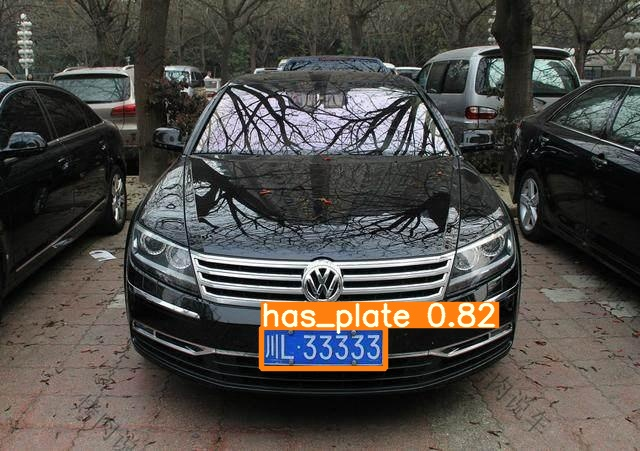

In [ ]:
from IPython.display import Image, clear_output
# !python detect.py --weights /content/drive/MyDrive/LPRNet_Weights/Yolov5/G_B.pt --img 640 --conf 0.25 --source /content/plates
Image(filename='/content/yolov5/runs/detect/exp3/川L33333.jpg', width=600)
# import os
# import matplotlib.pyplot as plt
# father_path = '/content/yolov5/runs/detect/exp3'
# image = cv2.imread('/content/yolov5/runs/detect/exp3/川L33333.jpg')
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.show()
# for root, dirs, files in os.walk(father_path):
#   for f in files:
#     print("识别的车牌结果是：" + f.split('.')[-2])
#     Image(filename='/content/yolov5/runs/detect/exp3/川L33333.jpg', width=600)